In [2]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
FACE_MESH = pd.read_csv('faceMesh/face_mesh.csv')

In [5]:
def landmarks_mapper(video: str, cleansed_data: bool):
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    if cleansed_data:
        OPENFACE_DIR = 'openFace/processed_cleansed/'
        MEDIAPIPE_DIR = 'mediaPipe/processed_cleansed/'
    else:
        OPENFACE_DIR = 'openFace/processed/'
        MEDIAPIPE_DIR = 'mediaPipe/processed/'
        
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame'] # initialize the final dataframe
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columns
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

# Pearson, R2 e CCC

In [6]:
def pearson(df: pd.DataFrame):
    
    lndmk_pearson = []
    for i in range(17, 68):
        
        x_pearson = pearsonr(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())[0]
        y_pearson = pearsonr(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())[0]
        lndmk_pearson.append((x_pearson+y_pearson)/2)
    
    video_pearson = np.mean(lndmk_pearson)
    
    return video_pearson

In [7]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

In [8]:
def r2(df: pd.DataFrame):
    
    lndmk_r2 = []
    for i in range(17, 68):
        
        x_r2 = r2_score(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_r2 = r2_score(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_r2.append((x_r2+y_r2)/2)
    
    video_r2 = np.mean(lndmk_r2)
    
    return video_r2

In [9]:
def rhoc(x,y):

    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    
    return rhoc

In [10]:
def ccc(df: pd.DataFrame):
    
    lndmk_ccc = []
    for i in range(17,68):
        
        x_ccc = rhoc(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())
        y_ccc = rhoc(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())
        lndmk_ccc.append((x_ccc+y_ccc)/2)
        
    video_ccc = np.mean(lndmk_ccc)
    
    return video_ccc

### Raw data

In [12]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, cleansed_data=False)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
%store extracted_features_df
extracted_features_df.to_csv('pearson_mse_r2_ccc.csv', index=False)
extracted_features_df

Stored 'extracted_features_df' (DataFrame)


,video,pearson,mse,r2,ccc
0,whack_your_boss_12,0.994929,8.845432,0.944251,0.973614
1,happy_wheels_54,0.982861,183.335608,0.947330,0.974229
2,would_you_rather_29,0.996142,15.780578,0.950409,0.976429
3,play_red_dead_138,0.843837,174.658153,0.535926,0.796190
4,Branda_schmitz_116,0.995133,20.777153,0.947977,0.975390
...,...,...,...,...,...
610,bully_burger_54,0.993922,11.339608,0.940392,0.971835
611,game_of_thrones_16,0.997744,9.924864,0.964629,0.982836
612,qwop_38,0.984433,41.320343,0.834965,0.932025
613,cuphead_58,0.992749,22.439067,0.948167,0.974880


### Cleansed data

In [13]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, cleansed_data=True)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df_cleansed = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
%store extracted_features_df_cleansed
extracted_features_df_cleansed.to_csv('pearson_mse_r2_ccc_cleansed.csv', index=False)
extracted_features_df_cleansed

Stored 'extracted_features_df_cleansed' (DataFrame)


,video,pearson,mse,r2,ccc
0,whack_your_boss_12,0.994929,8.845432,0.944251,0.973614
1,happy_wheels_54,0.982861,183.335608,0.947330,0.974229
2,would_you_rather_29,0.996142,15.780578,0.950409,0.976429
3,play_red_dead_138,0.843837,174.658153,0.535926,0.796190
4,Branda_schmitz_116,0.995133,20.777153,0.947977,0.975390
...,...,...,...,...,...
610,bully_burger_54,0.993922,11.339608,0.940392,0.971835
611,game_of_thrones_16,0.997744,9.924864,0.964629,0.982836
612,qwop_38,0.984433,41.320343,0.834965,0.932025
613,cuphead_58,0.992749,22.439067,0.948167,0.974880


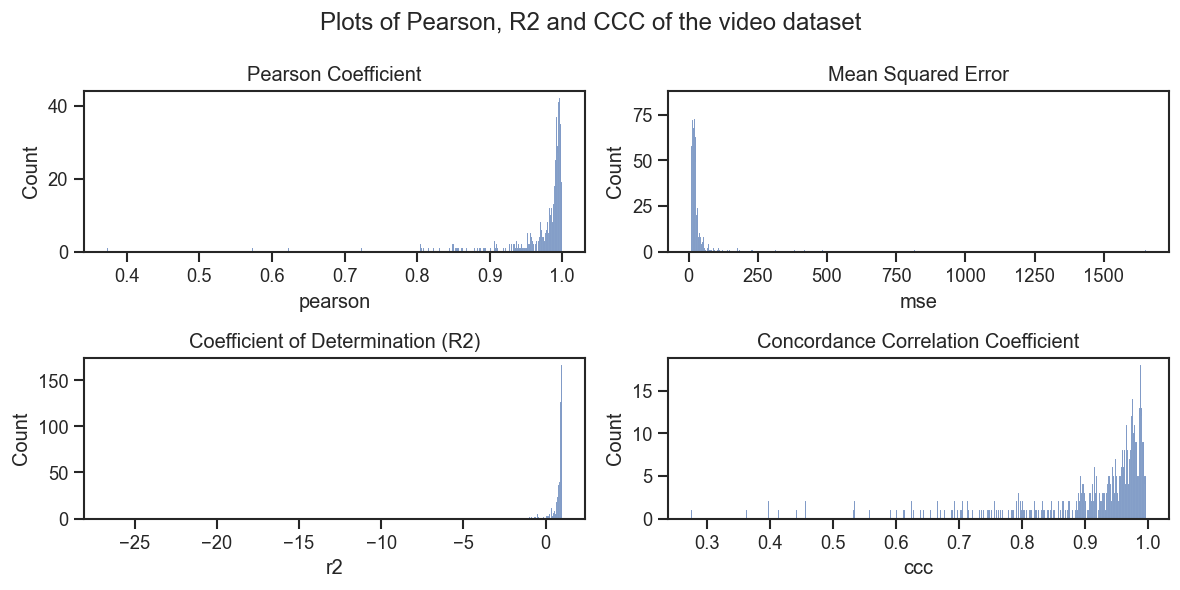

In [16]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")

fig, axes = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Plots of Pearson, R2 and CCC of the video dataset')
axes = axes.flatten()

# Pearson
axes[0].set_title('Pearson Coefficient')
sns.histplot(data=extracted_features_df_cleansed, x='pearson', bins=615, ax=axes[0])

# MSE
axes[1].set_title('Mean Squared Error')
sns.histplot(data=extracted_features_df_cleansed, x='mse', bins=615, ax=axes[1])

# R2
axes[2].set_title('Coefficient of Determination (R2)')
sns.histplot(data=extracted_features_df_cleansed, x='r2', bins=615, ax=axes[2])

# CCC
axes[3].set_title('Concordance Correlation Coefficient')
sns.histplot(data=extracted_features_df_cleansed, x='ccc', bins=615, ax=axes[3])

fig.tight_layout()
plt.show()

In [3]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.pearson < 0.8][['video', 'pearson']].sort_values(by='pearson')
videos_low_pearson = set(df['video'])
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(df))
df

Numero di video con coefficiente di Pearson minore di 0.8: 8


,video,pearson
373,gta2_26,0.372659
186,david_bowie_13,0.508014
367,play_lastofus_202,0.572700
440,50_50_70,0.622480
96,happy_wheels_97,0.652695
136,TRY_NOT_LOOK_AWAY_21,0.692060
63,fatality_9,0.724103
318,dolan_dark_75,0.774220


In [2]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.r2 < 0.5].sort_values(by='r2')
videos_low_r2 = set(df['video'])
print('Numero di video con R2 minore di 0.5:', len(df))
df

Numero di video con R2 minore di 0.5: 104


,video,pearson,r2,ccc
318,dolan_dark_75,0.774220,-26.681080,0.274845
136,TRY_NOT_LOOK_AWAY_21,0.692060,-17.041159,0.362347
493,50_50_77,0.830610,-15.769022,0.397240
367,play_lastofus_202,0.572700,-6.725543,0.456025
96,happy_wheels_97,0.652695,-6.581751,0.624155
...,...,...,...,...
319,play_red_dead_56,0.951695,0.460172,0.833398
244,cuphead_21,0.934122,0.475597,0.818732
525,play_lastofus_165,0.952283,0.480051,0.820177
330,japanese_show_85,0.974931,0.481210,0.825909


In [4]:
df = extracted_features_df_cleansed[extracted_features_df_cleansed.ccc < 0.8].sort_values(by='ccc')
videos_low_ccc = set(df['video'])
print('Numero di video con ccc minore di 0.8:', len(df))
df

Numero di video con ccc minore di 0.8: 88


,video,pearson,r2,ccc
318,dolan_dark_75,0.774220,-26.681080,0.274845
136,TRY_NOT_LOOK_AWAY_21,0.692060,-17.041159,0.362347
493,50_50_77,0.830610,-15.769022,0.397240
186,david_bowie_13,0.508014,-1.920150,0.397492
85,play_road_redemp_49,0.809551,-4.250506,0.413645
...,...,...,...,...
218,heartbeat_23,0.967683,0.245664,0.797000
490,qwop_93,0.934755,0.371203,0.797406
84,play_lastofus_146,0.956649,0.402055,0.798034
484,battlefield1_25,0.950067,0.078792,0.799125


In [5]:
videos_low_pearson.intersection(videos_low_r2).intersection(videos_low_ccc)

{'50_50_70',
 'TRY_NOT_LOOK_AWAY_21',
 'david_bowie_13',
 'dolan_dark_75',
 'fatality_9',
 'gta2_26',
 'happy_wheels_97',
 'play_lastofus_202'}